In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

def download_stock_data():
    nse_tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
                   'ICICIBANK.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'LT.NS', 'SBIN.NS',
                   'BAJFINANCE.NS', 'BHARTIARTL.NS', 'MARUTI.NS', 'ITC.NS', 'NTPC.NS']

    sse_tickers = ['000001.SS', '000002.SS', '600000.SS', '600036.SS', '600519.SS',
                   '600887.SS', '601012.SS', '601088.SS', '601166.SS', '601318.SS',
                   '601398.SS', '601857.SS', '601988.SS', '603259.SS', '000858.SZ']

    nyse_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'META', 'NVDA', 'JPM',
                    'V', 'JNJ', 'WMT', 'PG', 'UNH', 'MA', 'HD']

    all_tickers = nse_tickers + sse_tickers + nyse_tickers

    price_data = pd.DataFrame()

    for ticker in all_tickers:
        try:
            data = yf.download(ticker, start='2020-01-01', end='2023-12-31', auto_adjust=False, progress=False)
            if not data.empty and 'Adj Close' in data.columns:
                adj_close = data['Adj Close'].dropna()
                if len(adj_close) > 500:
                    price_data[ticker] = adj_close
        except:
            continue

    price_data = price_data.dropna(axis=1, thresh=len(price_data)*0.7)
    returns = price_data.pct_change().dropna()
    returns = returns.replace([np.inf, -np.inf], np.nan).fillna(0)

    print(f"Final dataset: {returns.shape[1]} assets, {returns.shape[0]} days")
    return returns, price_data



In [40]:
#HRP IMPLEMENTATION
def calculate_distance_matrix(corr_matrix):
    """Step 1: D(i,j) = sqrt(0.5 * (1 - ρ(i,j)))"""
    distance = np.sqrt(0.5 * (1 - corr_matrix))
    np.fill_diagonal(distance.values, 0)
    return distance

def hierarchical_clustering(distance_matrix):
    """Step 2: Single linkage clustering"""
    condensed_dist = squareform(distance_matrix.values, checks=False)
    linkage_matrix = linkage(condensed_dist, method='single')
    return linkage_matrix

def recursive_bisection_corrected(sorted_assets, cov_matrix):

    # Initialize all weights to 1
    weights = pd.Series(1.0, index=sorted_assets)
    clusters_to_process = [sorted_assets]
    iteration = 0

    while clusters_to_process:
        iteration += 1
        new_clusters = []

        for cluster in clusters_to_process:
            if len(cluster) <= 1:
                print(f"  Single asset cluster: {cluster}")
                continue

            # Split cluster in half
            mid_point = len(cluster) // 2
            cluster_1 = cluster[:mid_point]
            cluster_2 = cluster[mid_point:]

            print(f"  Splitting cluster of {len(cluster)} into {len(cluster_1)} and {len(cluster_2)}")

            def get_cluster_variance_corrected(cluster_assets):
                if len(cluster_assets) == 1:
                    return cov_matrix.loc[cluster_assets[0], cluster_assets[0]]

                cluster_cov = cov_matrix.loc[cluster_assets, cluster_assets]

                asset_vols = np.sqrt(np.diag(cluster_cov))
                inv_vol_weights = (1 / asset_vols) / (1 / asset_vols).sum()

                cluster_variance = inv_vol_weights @ cluster_cov @ inv_vol_weights
                return cluster_variance

            # Calculate variances for both clusters
            var_1 = get_cluster_variance_corrected(cluster_1)
            var_2 = get_cluster_variance_corrected(cluster_2)

            std_1 = np.sqrt(var_1)
            std_2 = np.sqrt(var_2)

            total_risk = std_1 + std_2
            if total_risk > 0:
                alpha_1 = std_2 / total_risk  # Cluster 1 gets weight proportional to Cluster 2's risk
                alpha_2 = std_1 / total_risk  # Cluster 2 gets weight proportional to Cluster 1's risk
            else:
                alpha_1 = alpha_2 = 0.5

            print(f"    Cluster 1 risk: {std_1:.4f}, gets weight: {alpha_1:.4f}")
            print(f"    Cluster 2 risk: {std_2:.4f}, gets weight: {alpha_2:.4f}")

            for asset in cluster_1:
                weights[asset] *= alpha_1
            for asset in cluster_2:
                weights[asset] *= alpha_2

            # Continue processing if clusters have multiple assets
            if len(cluster_1) > 1:
                new_clusters.append(cluster_1)
            if len(cluster_2) > 1:
                new_clusters.append(cluster_2)

        clusters_to_process = new_clusters

    # Normalize weights to sum to 1
    final_weights = weights / weights.sum()

    print(f"Final weights distribution:")
    print(f"  Min: {final_weights.min():.4f}")
    print(f"  Max: {final_weights.max():.4f}")
    print(f"  Std: {final_weights.std():.4f}")
    print(f"  Range: {final_weights.max() - final_weights.min():.4f}")

    return final_weights

def compute_hrp_weights(returns_data):
    print(f"Computing HRP weights for {len(returns_data.columns)} assets over {len(returns_data)} days")

    # Step 1: Correlation matrix
    corr_matrix = returns_data.corr().fillna(0)
    print(f"Correlation matrix: min={corr_matrix.min().min():.3f}, max={corr_matrix.max().max():.3f}")

    # Step 2: Distance matrix
    distance_matrix = calculate_distance_matrix(corr_matrix)

    # Step 3: Hierarchical clustering
    linkage_matrix = hierarchical_clustering(distance_matrix)

    # Step 4: Quasi-diagonalization
    ordered_indices = leaves_list(linkage_matrix)
    sorted_assets = [returns_data.columns[i] for i in ordered_indices]
    print(f"Asset ordering: {sorted_assets[:5]}...{sorted_assets[-5:]}")

    # Step 5: CORRECTED Recursive bisection
    cov_matrix = returns_data.cov().fillna(0)
    weights = recursive_bisection_corrected(sorted_assets, cov_matrix)

    return weights.reindex(returns_data.columns, fill_value=0), linkage_matrix, corr_matrix, distance_matrix



In [41]:

#REBALANCING
class HRPRebalancerDetailed:
    def __init__(self, returns, initial_weights):
        self.returns = returns
        self.weights_history = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)
        self.weights_history.iloc[0] = initial_weights.values
        self.portfolio_value = pd.Series(index=returns.index, dtype=float)
        self.portfolio_value.iloc[0] = 1.0
        self.rebalance_dates = []
        self.rebalance_details = []
        self.distance_changes = []
        self.last_distance_matrix = None
        self.last_rebalance_date = returns.index[0]

        print("="*80)
        print("REBALANCING LOGIC EXPLANATION:")
        print("="*80)
        print("1. TIME-BASED TRIGGER: Rebalance every 120 days (quarterly)")
        print("2. DISTANCE-BASED TRIGGER: Rebalance when Frobenius norm > 0.4")
        print("3. TRANSACTION COSTS: 0.3% applied ONLY on withdrawn amounts")
        print("4. WEIGHT CALCULATION: Full HRP recalculation each time")
        print("5. INITIAL WEIGHTS: Based on HRP clustering of first 126 days")
        print("="*80)

    def calculate_distance_change(self, current_returns, window=126):
        if len(current_returns) < window:
            return 0

        try:
            recent_returns = current_returns.iloc[-window:]
            corr_matrix = recent_returns.corr().fillna(0)
            current_distance = calculate_distance_matrix(corr_matrix)

            if self.last_distance_matrix is None:
                self.last_distance_matrix = current_distance
                return 0

            delta = np.linalg.norm(current_distance.values - self.last_distance_matrix.values, 'fro')
            self.last_distance_matrix = current_distance

            return delta if not (np.isnan(delta) or np.isinf(delta)) else 0
        except:
            return 0

    def run_backtest(self, distance_threshold=0.4, rebalance_frequency=120):
        print(f"Starting backtest with enhanced rebalancing logic...")
        print(f"Distance threshold: {distance_threshold}")
        print(f"Time frequency: {rebalance_frequency} days")

        for i in range(1, len(self.returns)):
            current_date = self.returns.index[i]
            returns_slice = self.returns.iloc[:i+1]

            # Calculate distance change
            distance_delta = self.calculate_distance_change(returns_slice)
            self.distance_changes.append(distance_delta)

            # Check triggers
            days_since_last = (current_date - self.last_rebalance_date).days
            time_trigger = days_since_last >= rebalance_frequency
            distance_trigger = distance_delta > distance_threshold

            if time_trigger or distance_trigger:
                reason = f"Time-based ({days_since_last} days)" if time_trigger else f"Structure change (Δ={distance_delta:.3f})"

                try:
                    print(f"\nREBALANCING EVENT #{len(self.rebalance_dates)+1}")
                    print(f"Date: {current_date.date()}")
                    print(f"Reason: {reason}")

                    # Calculate NEW HRP weights
                    new_weights, _, _, _ = compute_hrp_weights_corrected(returns_slice)
                    old_weights = self.weights_history.iloc[i-1]

                    print(f"Old weights: min={old_weights.min():.4f}, max={old_weights.max():.4f}, std={old_weights.std():.4f}")
                    print(f"New weights: min={new_weights.min():.4f}, max={new_weights.max():.4f}, std={new_weights.std():.4f}")

                    # Apply transaction costs ONLY on withdrawals
                    withdrawals = (old_weights - new_weights).clip(lower=0)
                    total_withdrawal = withdrawals.sum()
                    costs = withdrawals * 0.003  # 0.3% cost
                    total_cost = costs.sum()

                    print(f"Total withdrawal: {total_withdrawal:.4f} ({total_withdrawal*100:.2f}%)")
                    print(f"Transaction cost: {total_cost:.4f} ({total_cost*100:.2f}%)")

                    # Adjust weights
                    adjusted_weights = new_weights + (old_weights - new_weights - costs)
                    adjusted_weights = adjusted_weights.clip(lower=0.001)
                    adjusted_weights = adjusted_weights / adjusted_weights.sum()

                    print(f"Final weights: min={adjusted_weights.min():.4f}, max={adjusted_weights.max():.4f}, std={adjusted_weights.std():.4f}")

                    # Store results
                    self.weights_history.iloc[i] = adjusted_weights.values
                    self.rebalance_dates.append(current_date)
                    self.rebalance_details.append({
                        'date': current_date,
                        'reason': reason,
                        'distance_delta': distance_delta,
                        'total_cost': total_cost,
                        'weight_change': abs(adjusted_weights - old_weights).sum()
                    })
                    self.last_rebalance_date = current_date

                except Exception as e:
                    print(f"Rebalancing failed: {e}")
                    self.weights_history.iloc[i] = self.weights_history.iloc[i-1]
            else:
                # No rebalancing
                self.weights_history.iloc[i] = self.weights_history.iloc[i-1]

            # Calculate portfolio value
            try:
                daily_return = (self.weights_history.iloc[i] * self.returns.iloc[i]).sum()
                if np.isnan(daily_return) or np.isinf(daily_return):
                    daily_return = 0
                self.portfolio_value.iloc[i] = self.portfolio_value.iloc[i-1] * (1 + daily_return)
            except:
                self.portfolio_value.iloc[i] = self.portfolio_value.iloc[i-1]

        return (self.weights_history, self.portfolio_value, self.rebalance_dates,
                pd.Series(self.distance_changes, index=self.returns.index[1:]))

# ========== EXECUTION ==========
returns, prices = download_stock_data()

if returns.empty:
    print("❌ No data available")
    exit()

# Calculate initial weights
print("\n" + "="*80)
print("INITIAL WEIGHT ASSIGNMENT LOGIC:")
print("="*80)
print("1. Use first 126 days (6 months) of data for initial HRP calculation")
print("2. HRP clusters assets by correlation similarity")
print("3. Within each cluster: inverse volatility weighting")
print("4. Between clusters: inverse risk weighting")
print("5. Final weights should show CLEAR differentiation (not equal)")
print("="*80)

initial_weights, linkage_matrix, corr_matrix, distance_matrix = compute_hrp_weights_corrected(returns.iloc[:126])

# Run backtest
rebalancer = HRPRebalancerDetailed(returns, initial_weights)
weights_history, portfolio_value, rebalance_dates, distance_changes = rebalancer.run_backtest()



Streaming output truncated to the last 5000 lines.
    Cluster 2 risk: 0.0188, gets weight: 0.3398
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0147, gets weight: 0.5666
    Cluster 2 risk: 0.0193, gets weight: 0.4334
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0218, gets weight: 0.4839
    Cluster 2 risk: 0.0204, gets weight: 0.5161
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0253, gets weight: 0.5407
    Cluster 2 risk: 0.0298, gets weight: 0.4593
  Splitting cluster of 2 into 1 and 1
    Cluster 1 risk: 0.0372, gets weight: 0.4369
    Cluster 2 risk: 0.0288, gets weight: 0.5631
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0324, gets weight: 0.4955
    Cluster 2 risk: 0.0318, gets weight: 0.5045
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0314, gets weight: 0.4623
    Cluster 2 risk: 0.0270, gets weight: 0.5377
  Splitting cluster of 3 into 1 and 2
    Cluster 1 risk: 0.0294, gets weight: 0.4122
    Cluster

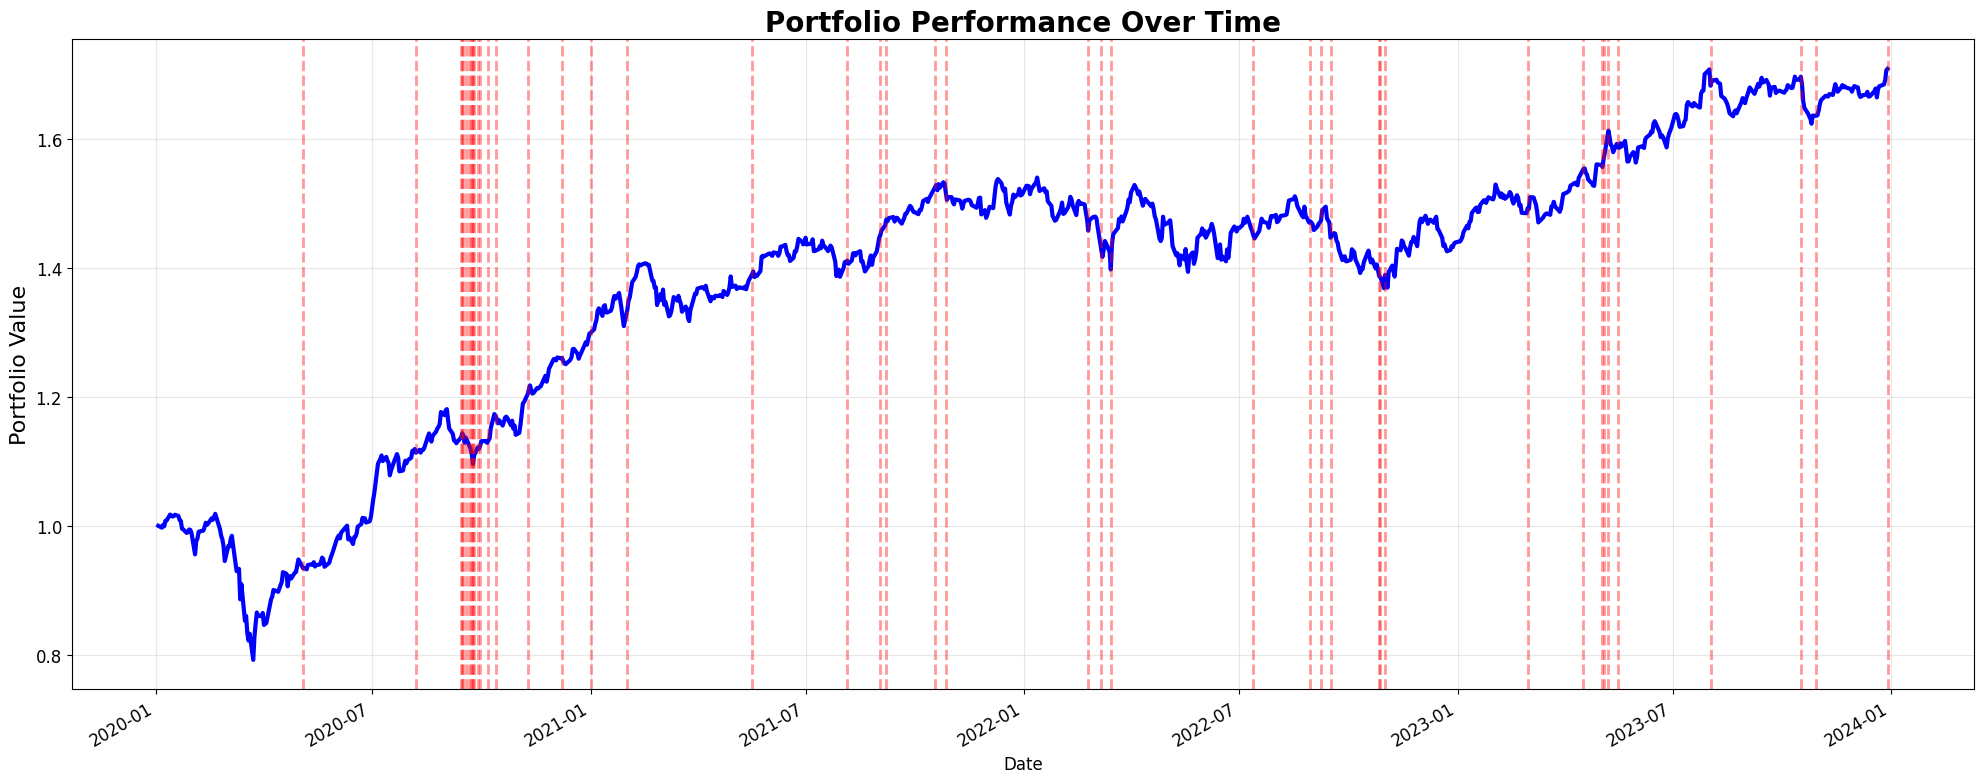

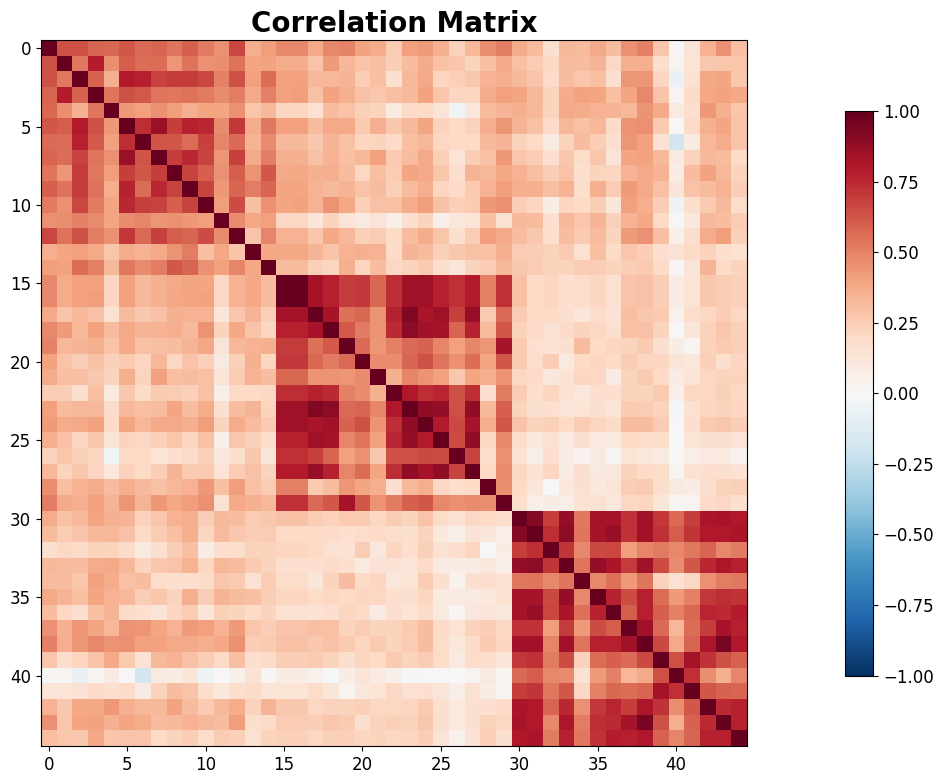

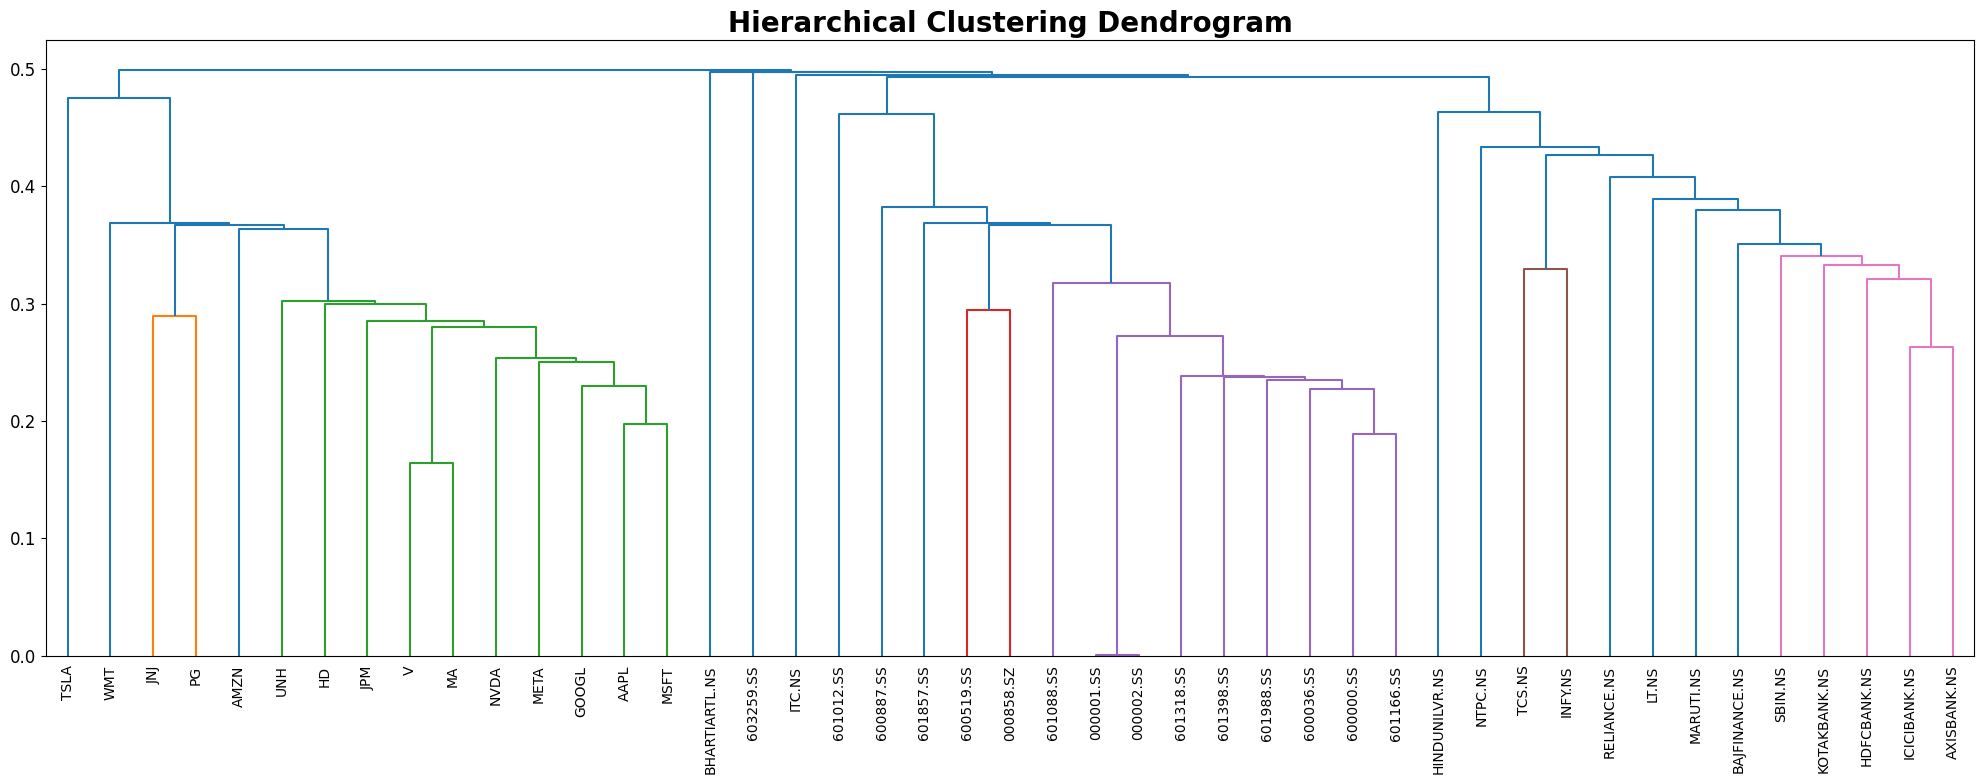

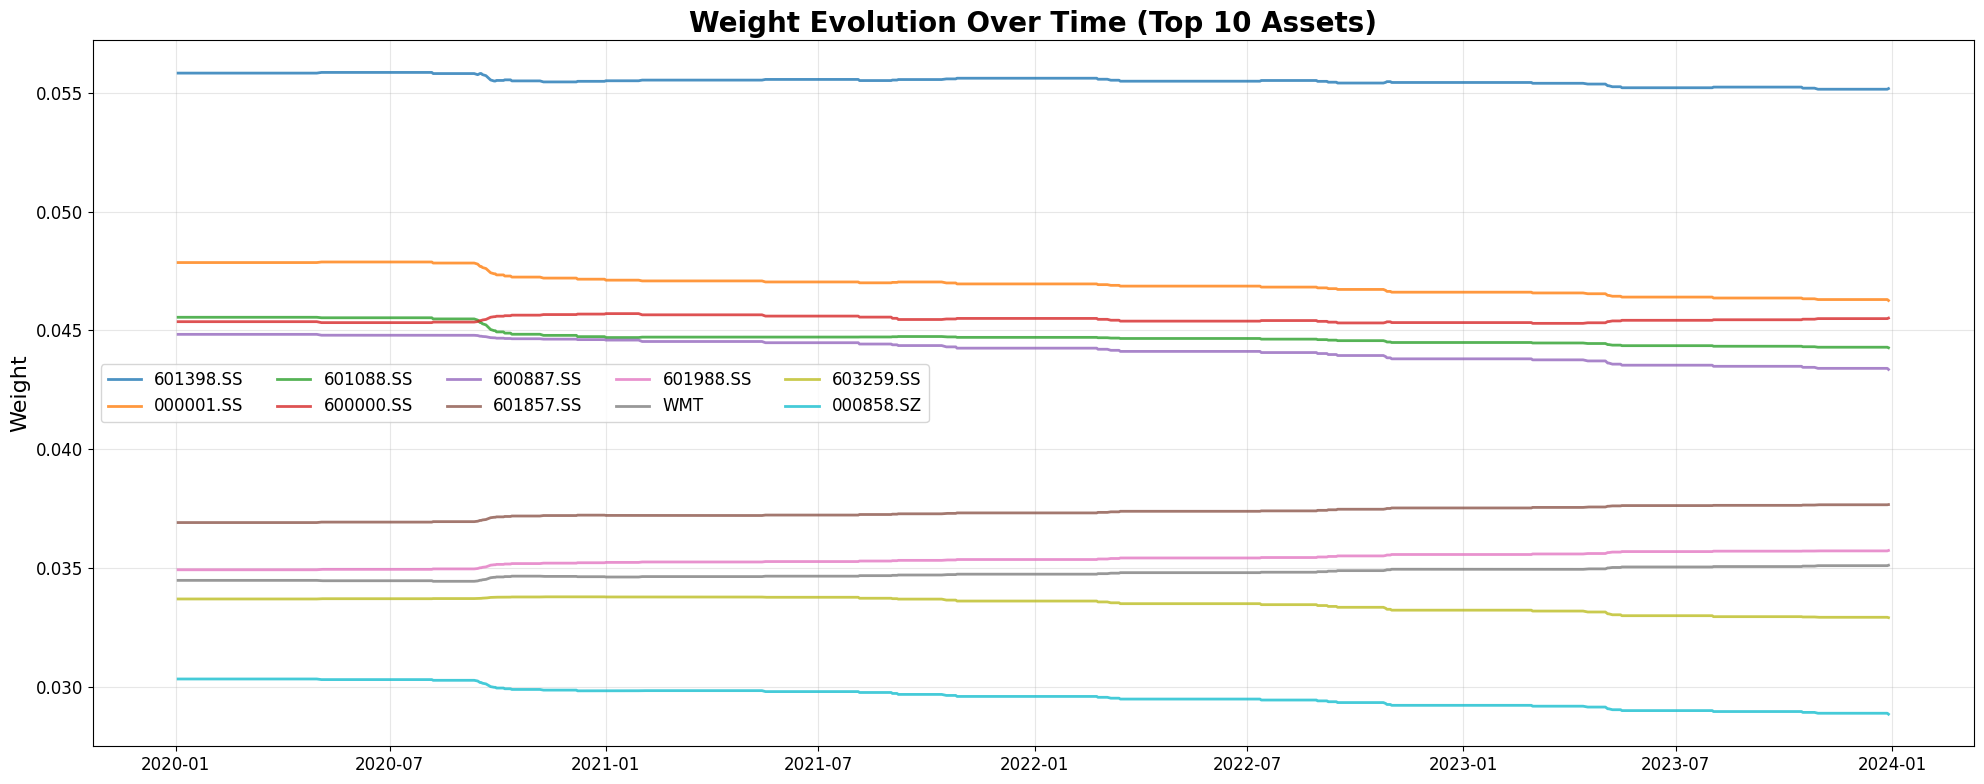

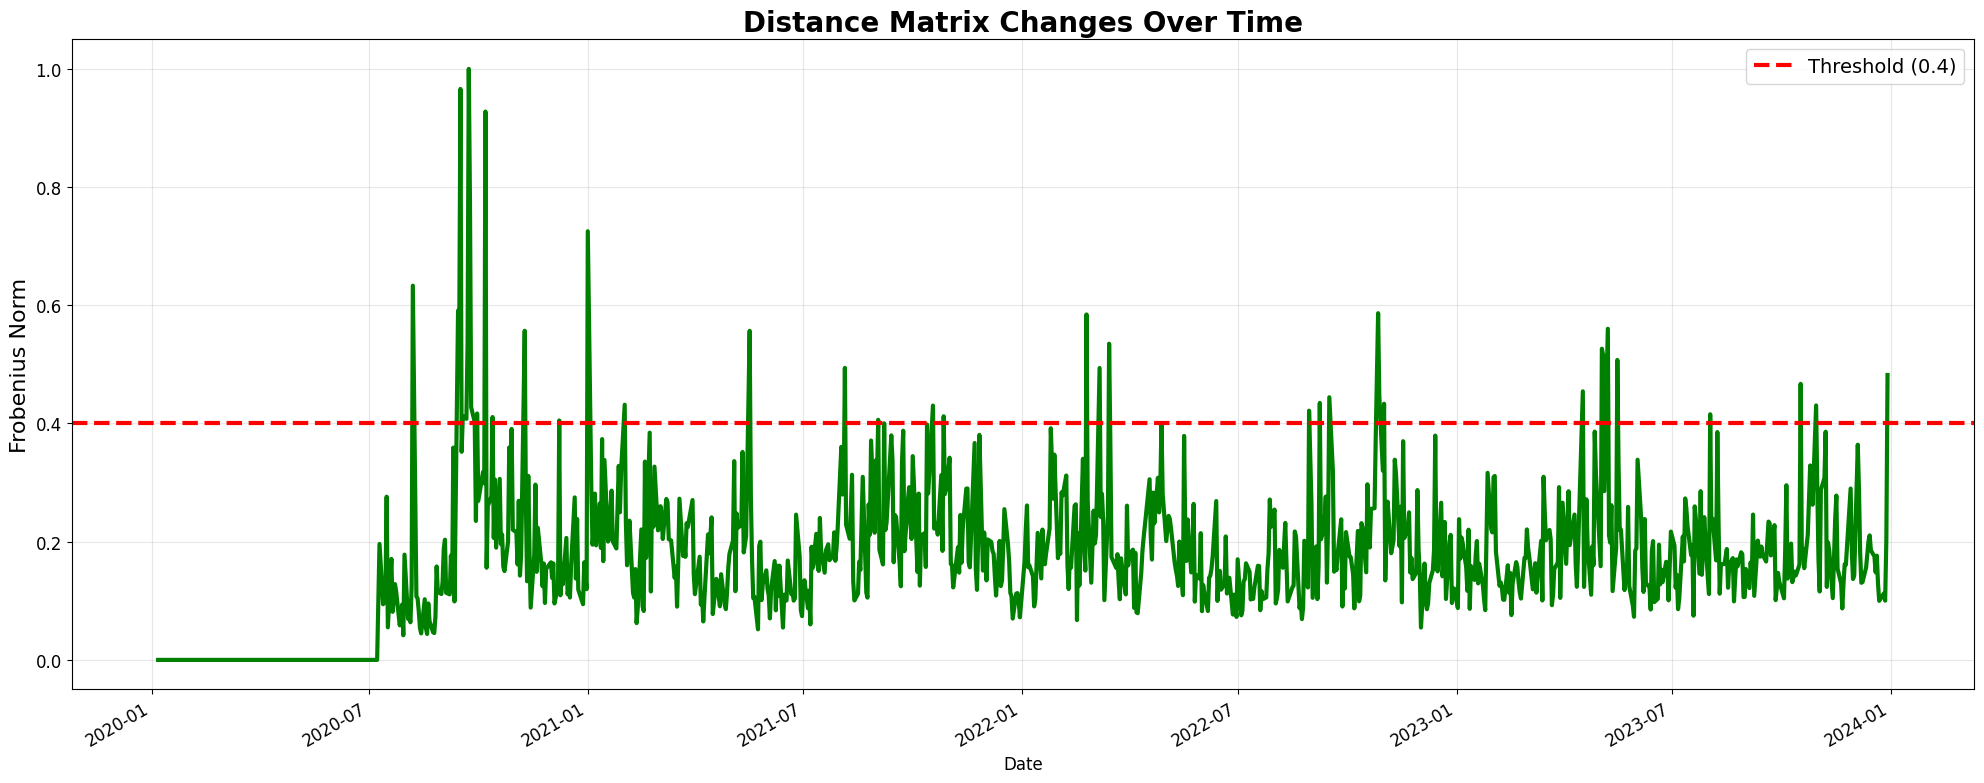

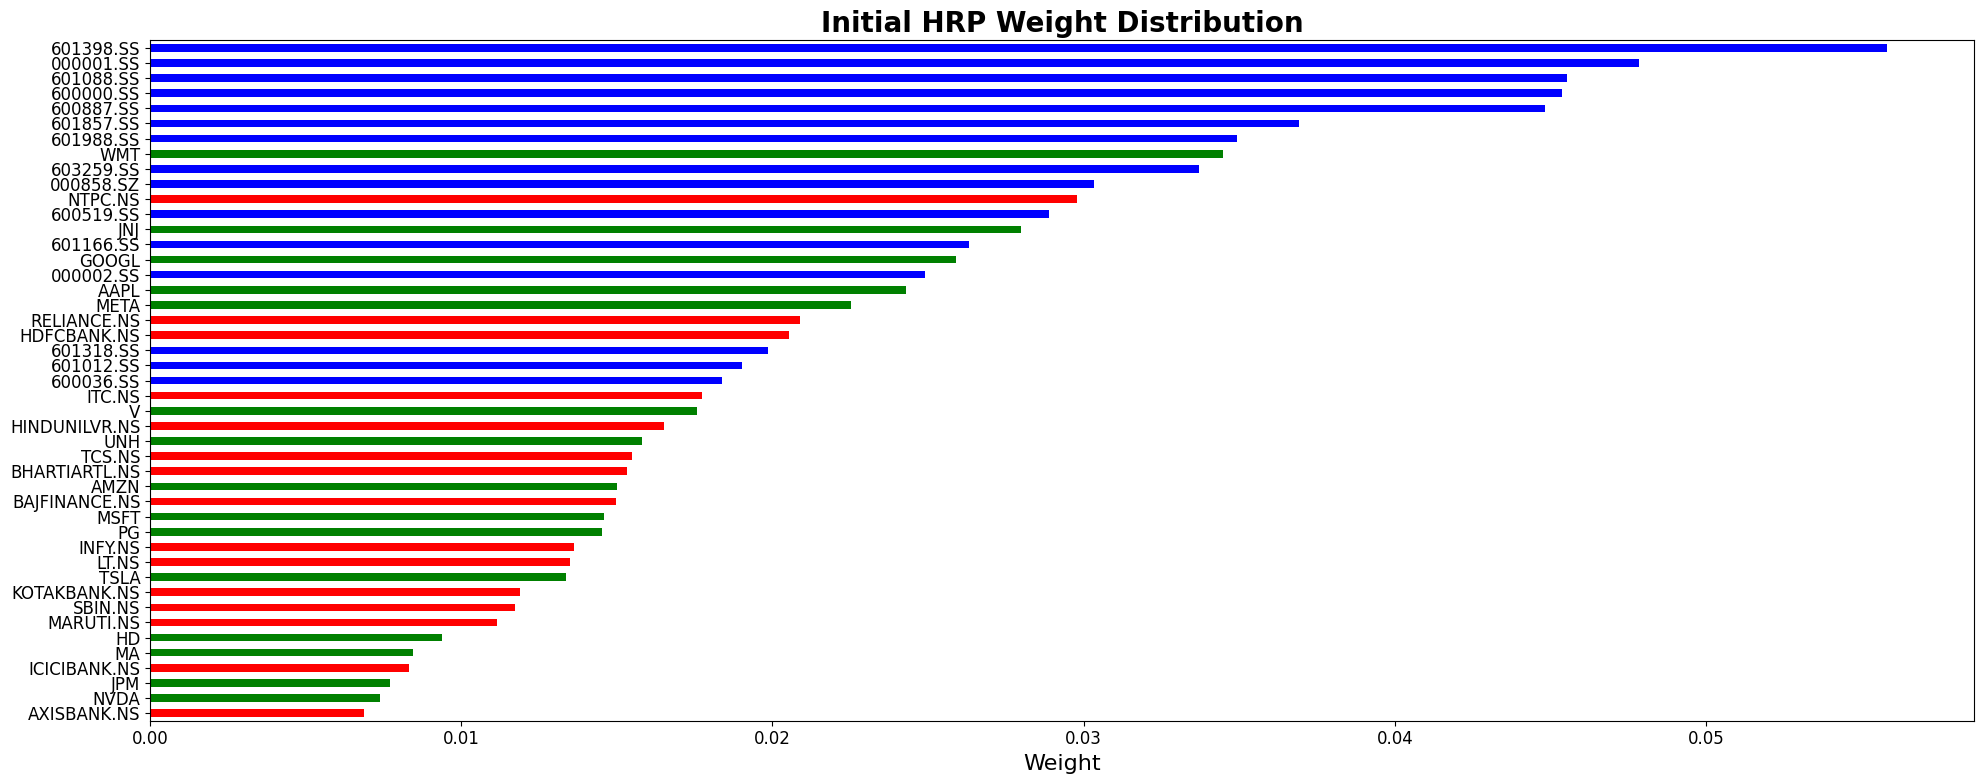

In [42]:
# Plot 1: Portfolio Performance (FULL WIDTH)
plt.figure(figsize=(20, 8))
portfolio_value.plot(color='blue', linewidth=3)
for date in rebalance_dates:
    plt.axvline(x=date, color='red', alpha=0.4, linestyle='--', linewidth=2)
plt.title('Portfolio Performance Over Time', fontweight='bold', fontsize=20)
plt.ylabel('Portfolio Value', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Correlation Matrix (FULL WIDTH)
plt.figure(figsize=(20, 8))
im1 = plt.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im1, shrink=0.8)
plt.title('Correlation Matrix', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()

# Plot 3: Hierarchical Clustering Dendrogram (FULL WIDTH)
plt.figure(figsize=(20, 8))
dendrogram(linkage_matrix, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()

# Plot 4: Weight Evolution (FULL WIDTH)
plt.figure(figsize=(20, 8))
# Show top 10 assets for clarity
top_assets = initial_weights.nlargest(10).index
for asset in top_assets:
    plt.plot(weights_history.index, weights_history[asset], label=asset, alpha=0.8, linewidth=2)
plt.title('Weight Evolution Over Time (Top 10 Assets)', fontweight='bold', fontsize=20)
plt.ylabel('Weight', fontsize=16)
plt.legend(fontsize=12, ncol=5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 5: Distance Changes (FULL WIDTH)
plt.figure(figsize=(20, 8))
distance_changes.plot(color='green', linewidth=3)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=3, label='Threshold (0.4)')
plt.title('Distance Matrix Changes Over Time', fontweight='bold', fontsize=20)
plt.ylabel('Frobenius Norm', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 6: Initial Weight Distribution (FULL WIDTH)
plt.figure(figsize=(20, 8))
weights_sorted = initial_weights.sort_values(ascending=True)
colors = ['red' if '.NS' in x else 'blue' if any(z in x for z in ['.SS', '.SZ']) else 'green'
          for x in weights_sorted.index]
weights_sorted.plot.barh(color=colors)
plt.title('Initial HRP Weight Distribution', fontweight='bold', fontsize=20)
plt.xlabel('Weight', fontsize=16)
plt.tight_layout()
plt.show()



In [43]:
# ========== PERFORMANCE METRICS ==========
portfolio_returns = portfolio_value.pct_change().dropna()
clean_returns = portfolio_returns.replace([np.inf, -np.inf], np.nan).dropna()

if len(clean_returns) > 0:
    annual_return = clean_returns.mean() * 252
    annual_volatility = clean_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0

    cumulative_returns = (1 + clean_returns).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = abs(drawdowns.min())

    print("\n" + "="*80)
    print("="*80)
    print(f"Assets in Portfolio      : {len(weights_history.columns)}")
    print(f"Total Rebalances         : {len(rebalance_dates)}")
    print(f"Annual Return            : {annual_return:.2%}")
    print(f"Annual Volatility        : {annual_volatility:.2%}")
    print(f"Sharpe Ratio             : {sharpe_ratio:.3f}")
    print(f"Maximum Drawdown         : {max_drawdown:.2%}")
    print(f"Total Return             : {(cumulative_returns.iloc[-1] - 1):.2%}")


print("\n✅ CORRECTED HRP Analysis Complete!")


Assets in Portfolio      : 45
Total Rebalances         : 45
Annual Return            : 14.53%
Annual Volatility        : 13.27%
Sharpe Ratio             : 1.095
Maximum Drawdown         : 22.24%
Total Return             : 70.84%

✅ CORRECTED HRP Analysis Complete!
